In [1]:
from pathlib import Path

import numpy as np
import cv2

from google.colab.patches import cv2_imshow

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, GenericMask
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo

from settings.paths import FILES_DIR, MODEL_DIR

/Users/markantipin/Desktop/Systemka/Segmentator/venv/lib/python3.6/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
cfg = get_cfg()

cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

cfg.MODEL.WEIGHTS = Path(MODEL_DIR, "model_final.pth").as_posix()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)

In [3]:
fashion_metadata = MetadataCatalog.get('fashion').set(
            thing_classes=[
                'short sleeve top',
                'long sleeve top',
                'short sleeve outwear',
                'long sleeve outwear',
                'vest',
                'sling',
                'shorts',
                'skirt',
                'trousers',
                'short sleeve dress',
                'long sleeve dress',
                'vest dress',
                'sling dress'
            ])

In [4]:
test_image_path = Path(FILES_DIR, 'look2.jpg').as_posix()

In [5]:
im = cv2.imread(test_image_path)

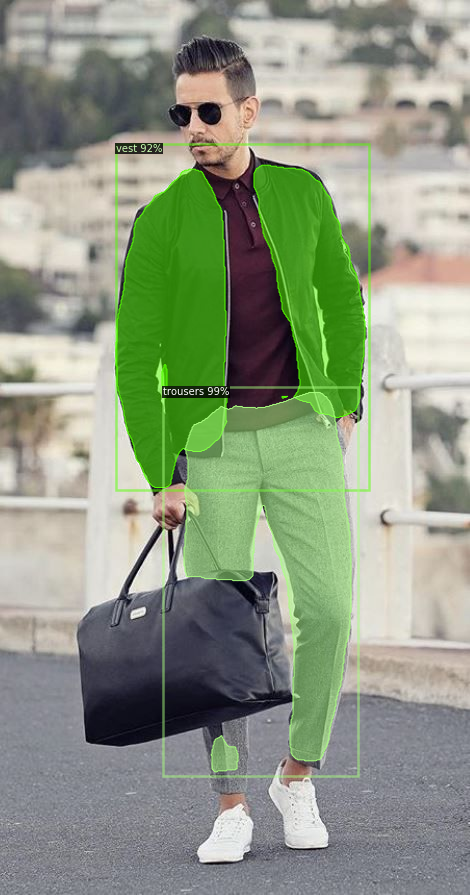

In [6]:
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata=fashion_metadata)
picture = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(picture.get_image()[:, :, ::-1])

In [14]:
predictions = outputs["instances"].to("cpu")

In [18]:
masks = np.asarray(predictions.pred_masks)
masks = [GenericMask(x, v.output.height, v.output.width) for x in masks]

In [25]:
masks = convert_masks(masks)

In [27]:
areas = np.asarray([x.area() for x in masks])

In [29]:
sorted_idxs = np.argsort(-areas).tolist()

In [64]:
masks = [masks[idx] for idx in sorted_idxs]
boxes = [outputs["instances"].pred_boxes[idx] for idx in sorted_idxs]

In [65]:
boxes

[Boxes(tensor([[115.8570, 144.4249, 369.2998, 490.4273]])),
 Boxes(tensor([[162.7663, 387.4076, 358.4285, 776.0428]]))]

In [66]:
for i, box in zip(range(len(masks)), boxes):
    background = np.ones(image.shape, dtype=np.uint8)
    background.fill(255)
    for j, segment in enumerate(masks[i].polygons):

        item_mask = np.array([segment.reshape(-1, 2)], dtype=np.int32)
        
        cv2.fillPoly(background, item_mask, 0)
    masked_image = cv2.bitwise_or(image, background)
    x1, y1, x2, y2 = [round(cord) for cord in box.tensor.tolist()[0]]
    crop_img = masked_image[y1:y2, x1:x2]
    cv2.imwrite(f"{i}.png", crop_img)

In [39]:
    for box in outputs["instances"].pred_boxes:
        x1, y1, x2, y2 = [round(cord) for cord in box.tolist()]
        crop_img = image[y1:y2, x1:x2]

True

In [ ]:

for box, segment in zip(outputs["instances"].pred_boxes, masks[0].polygons):
    x1, y1, x2, y2 = [round(cord) for cord in box.tolist()]
    croped = im[y1:y2, x1:x2].copy()
    
    background = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(background, background, mask=segment.reshape(-1, 2))
    dst2 = background + dst
    
    cv2.imwrite("dst2.png", dst2)
    
    

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/core/src/arithm.cpp:250: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'
